#### **Import Libraries**

In [15]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5, 2)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.unicode_minus'] = False

#### **Load Dataset**
- 1번함체: CG_1(이격), CG_2(침하) // TT_1 (상부경사), TT_2 (하부경사)
- 2번함체: CG_3(이격), CG_4(침하) // TT_3 (상부경사), TT_4 (하부경사)
- 온도: TC_1_Avg(concrete temp), TC_2_Avg(air temp)
- Label: 0(baseline), 1(outliers) // 2023.01.01: Initial point for abnomaly

In [16]:
# Define filename
fn_name = 'J_Dataset_1101_0630.csv'
# fn_name = 'J_Dataset_1101_0630_outlier_1sig.csv'
# fn_name = 'J_Dataset_1101_0630_outlier_2sig.csv'
# fn_name = 'J_Dataset_1101_0630_outlier_3sig.csv'

# Read csv file
df = pd.read_csv(fn_name)

# Convert string in time column to datatime (Change data type)
df.Time = pd.to_datetime(df.Time)

# Define columnnames for seperating CAISSON1 & CAISSON2
df1_col = ['Time', 'CG_1', 'CG_2', 'TT_1', 'TT_2', 'TC_1_Avg', 'TC_2_Avg', 'Waterlevel']
df3_col = ['Time', 'CG_3', 'CG_4', 'TT_3', 'TT_4', 'TC_1_Avg', 'TC_2_Avg', 'Waterlevel']

# Rename the column names, since original files have different name of labels.
if 'Label_1' in df.columns:
    df1_col.append('Label_1')
    df1 = df[df1_col]
    df1.columns = ['Label'  if col_[:5] == 'Label' else col_ for col_ in df1.columns]

    df3_col.append('Label_2')
    df3 = df[df3_col]
    df3.columns = ['Label'  if col_[:5] == 'Label' else col_ for col_ in df3.columns]
else:
    df1_col.append('Label')
    df1 = df[df1_col]
    df3_col.append('Label')
    df3 = df[df3_col]

print('=========' * 5)
print(f'Caisson #1: shape = {df1.shape}')
display(df1)
# print('=========' * 5)
# print(f'Caisson #3: shape = {df3.shape}')
# display(df3)

Caisson #1: shape = (34037, 9)


,Time,CG_1,CG_2,TT_1,TT_2,TC_1_Avg,TC_2_Avg,Waterlevel,Label
0,2022-11-01 00:00:00,0.000000,0.000000,0.000000,0.000000,13.06,14.44,563.0,0
1,2022-11-01 00:10:00,0.002000,-0.003000,0.000000,0.000000,13.07,14.56,543.0,0
2,2022-11-01 00:20:00,0.005000,-0.005000,-0.001000,0.000000,13.10,14.38,523.0,0
3,2022-11-01 00:30:00,0.008000,-0.007000,-0.001000,0.000000,13.13,14.34,504.0,0
4,2022-11-01 00:40:00,0.011000,-0.009000,-0.001000,0.000000,13.16,14.45,484.0,0
...,...,...,...,...,...,...,...,...,...
34032,2023-06-30 23:10:00,-1.363999,-0.347368,0.048206,0.297531,25.93,23.42,458.0,1
34033,2023-06-30 23:20:00,-1.355999,-0.348368,0.047206,0.297531,25.82,23.29,480.0,1
34034,2023-06-30 23:29:59,-1.347999,-0.349368,0.047206,0.297531,25.72,23.24,503.0,1
34035,2023-06-30 23:40:00,-1.339999,-0.350368,0.047206,0.296531,25.65,23.15,527.0,1


#### **Step 1: Exploaratory Data Analysis (EDA)**

##### **Define helper functions for EDA**

In [17]:
# Extract indices for normal, abnormals for plot and train_test_split
def find_indices_labels(df):
    index_ = []
    for ind in df.Label.unique():
        index_.append(df.Label == ind)
    return index_
    
# Plot label information over time
def plot_data_labels(df, color_type_str = ['blue', 'orange', 'red']):
    # Extract indices for normal & abnormals
    df_ind = find_indices_labels(df)

    # Plot scatter plot (Time index vs. Label)
    plt.figure(figsize = (10, 3))
    for label_ind in range(len(df_ind)):
        indice_ = df_ind[label_ind]
        plt.plot(df.Time[indice_], df.Label[indice_], marker = '.', color = color_type_str[label_ind])
    plt.xlabel('Time')
    plt.ylabel('Label')
    plt.gca().set_yticks([0, label_ind])
    plt.grid(linestyle = ':')
    if 'CG_1' in df.columns:
        plt.title('Caisson #1')
    else:
        plt.title('Caisson #3')
    plt.show()

# Plot measurements over time
def show_lineplots_data(df, cols_interest = None,  color_type_str = ['blue', 'orange', 'red']):
    # If there is no column of interest, define default list of columns
    if cols_interest is None:
        cols_interest = [f'CG_{i}' for i in range(1, 5)] + [f'TT_{i}' for i in range(1, 5)]


    # Extract indices for normal & abnormals
    df_ind = find_indices_labels(df)

    for col0_ in df.columns:
        if col0_ in cols_interest:
            plt.figure(figsize = (10, 3))
            for label_ind in range(len(df_ind)):
                indice_ = df_ind[label_ind]
                plt.plot(df.Time[indice_], df.loc[:, col0_][indice_], marker = '.', color = color_type_str[label_ind])

            plt.xlabel('Time')
            plt.ylabel(col0_)

            plt.grid(linestyle = ':')
            if 'CG_1' in df.columns:
                plt.title('Caisson #1')
            else:
                plt.title('Caisson #3')
            plt.show()


# Show pairplots in bivariate plot
def show_scatter_plots_data(df, col_interest, df_interest = None):
    if df_interest is None:
        X = df[col_interest]
    else:
        index_interest = []
        for i, index_ in enumerate(df_interest):
            if i == 0:
                index_interest = index_
            else:
                index_interest += index_
        X = df[col_interest].loc[index_interest]

    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list('blue-yellow', ['blue', 'red'])

    if len(df_interest) > 2:
        markers=["o", "s", 'd']
    else:
        markers=["o","s"]


    g = sns.pairplot(X, hue="Label", kind='reg', plot_kws={'scatter_kws': {'s':12, 'alpha': 0.3, 'edgecolor':"none"}}, corner=True, markers=markers)
    for ax in g.axes.flat:
        if ax is not None and not ax in g.diag_axes:
            for collection in ax.collections:
                collection.set_cmap(cmap)
                collection.set_array(X.index.to_numpy())
    plt.show()

In [18]:
# # Extract indices for normal & abnormals
df_ind = find_indices_labels(df1)

damage_ind = []
for ind in range(len(df_ind)):
    if len(df_ind) == 1:
        print(f'No abnormal condition occurs')
    else:
        if ind > 0:
            damage_ind.append(np.where(df_ind[ind] == True)[0][-1] + 1)
            print(f'Sample Index of #{ind} shift (abrnomaly): {damage_ind[-1]}')

Sample Index of #1 shift (abrnomaly): 34037


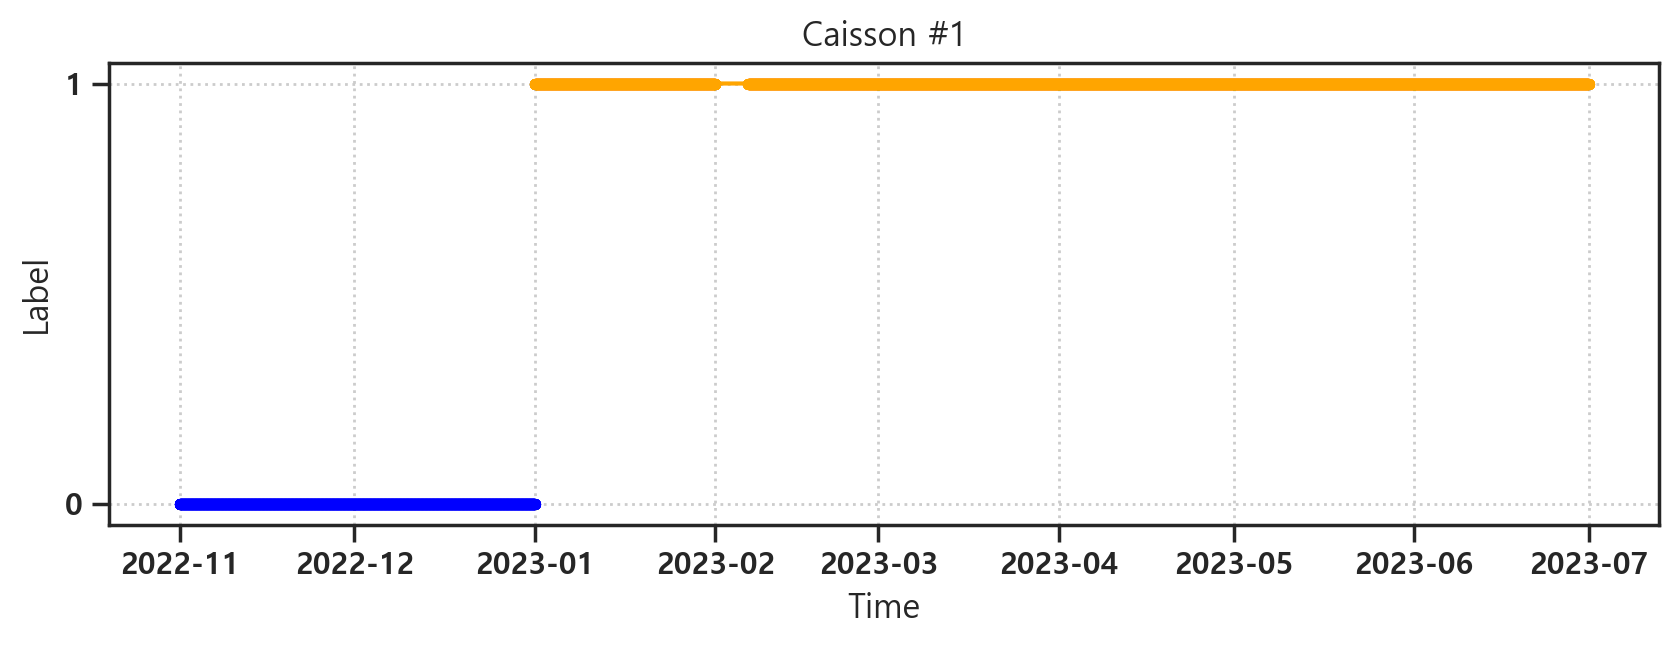

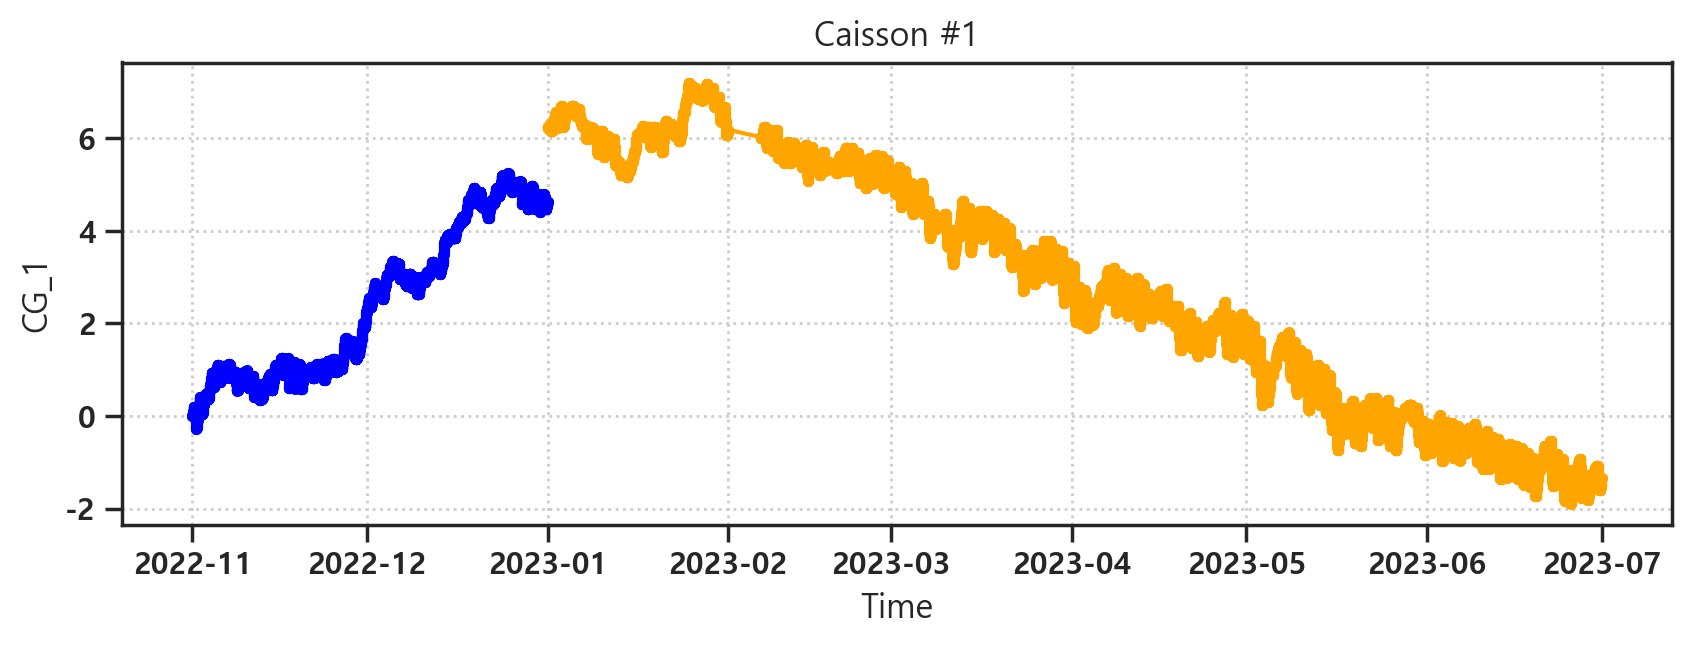

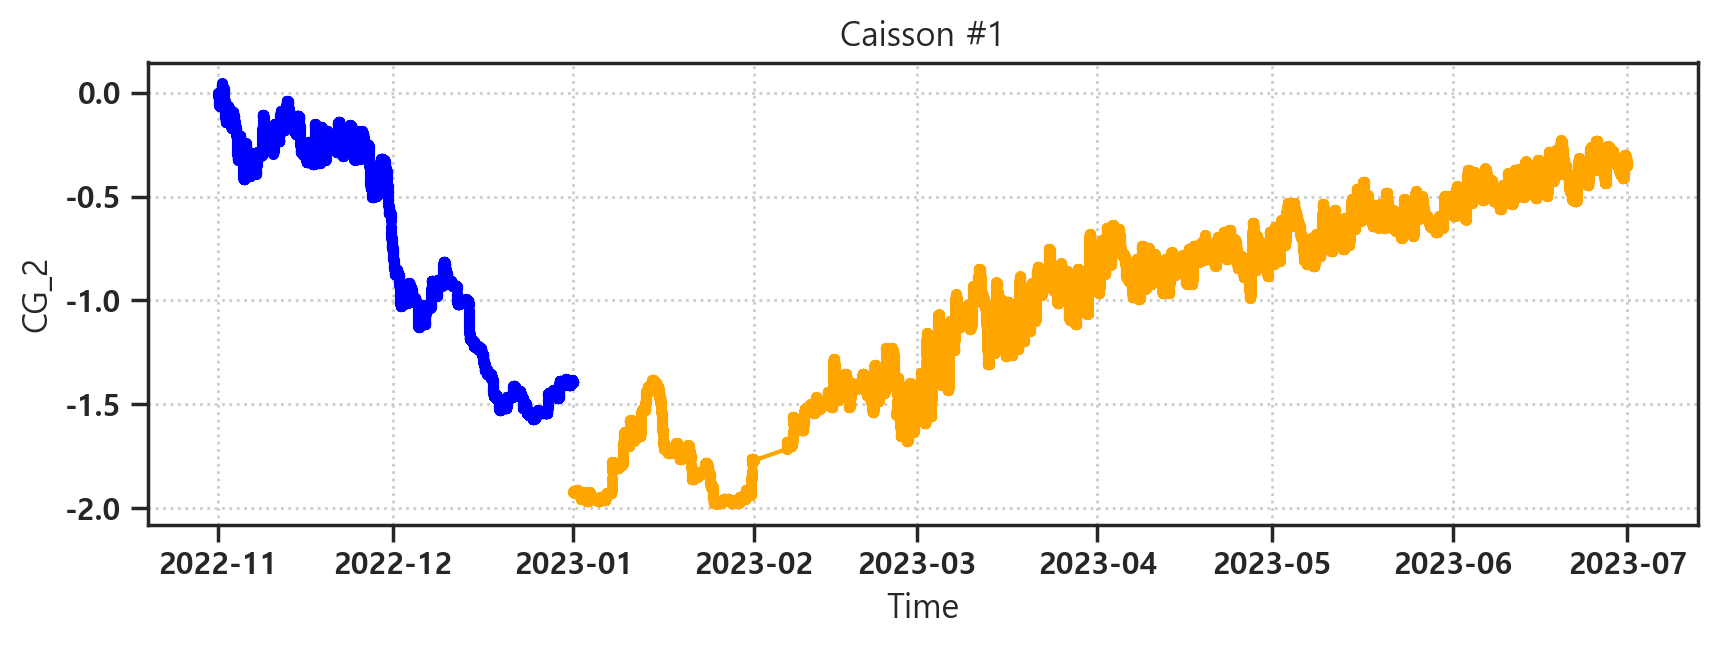

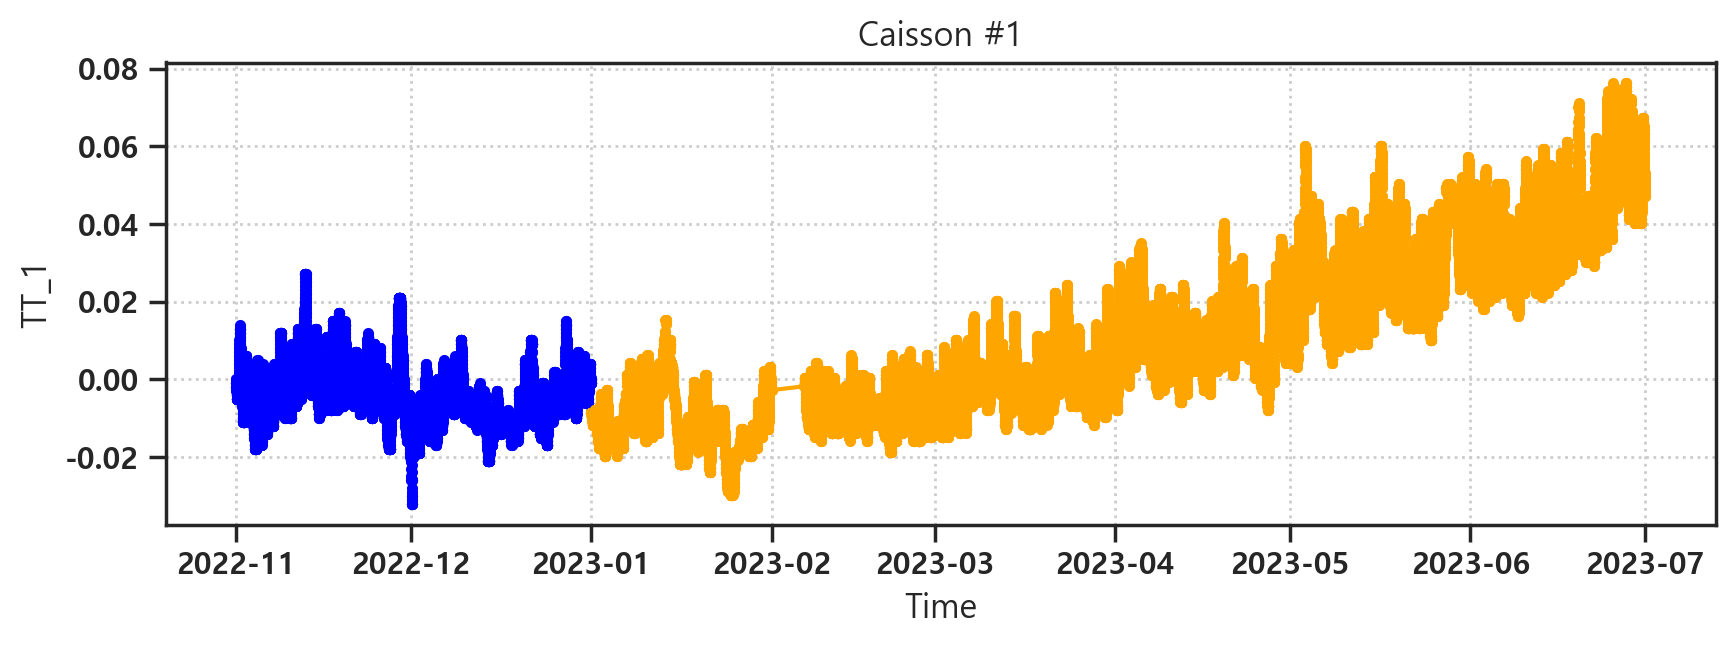

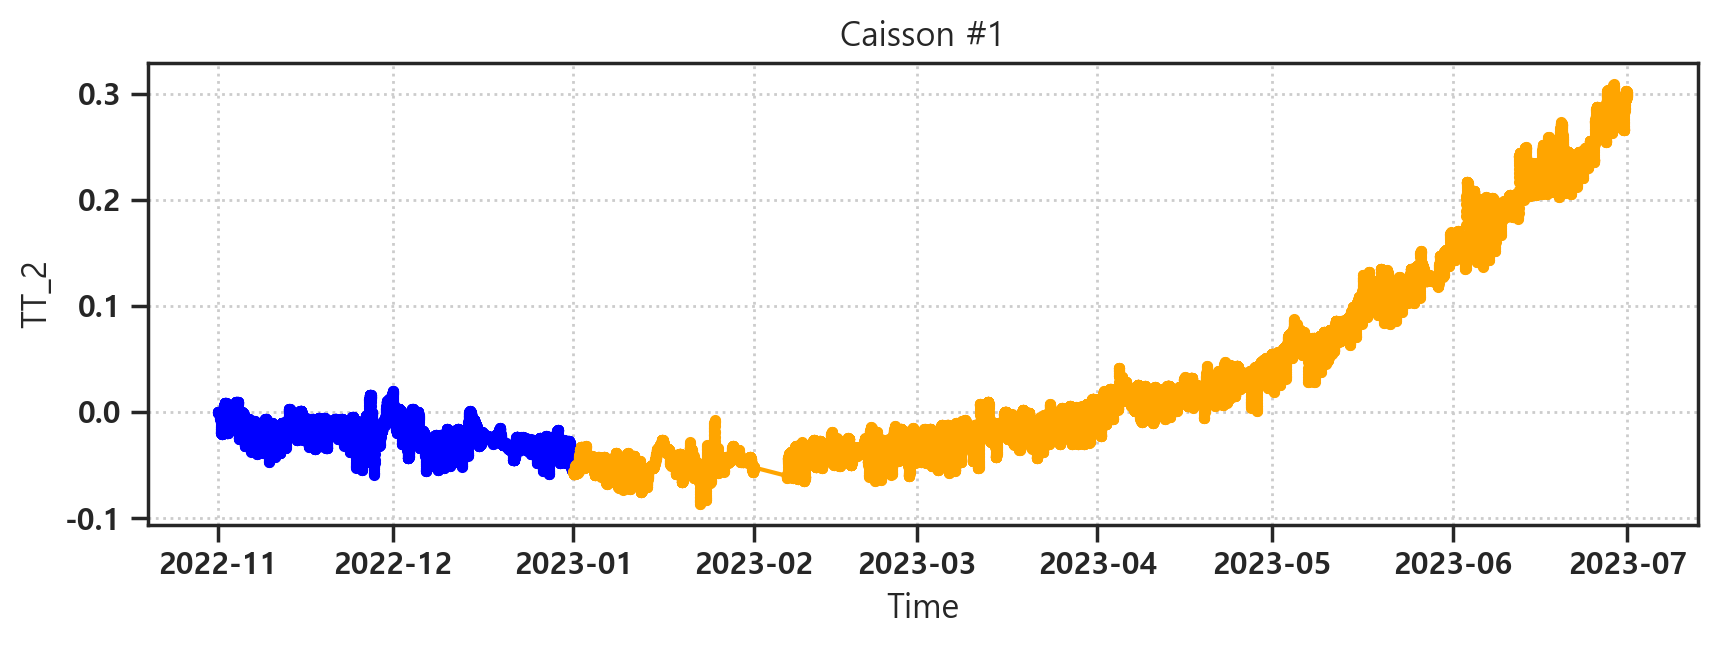

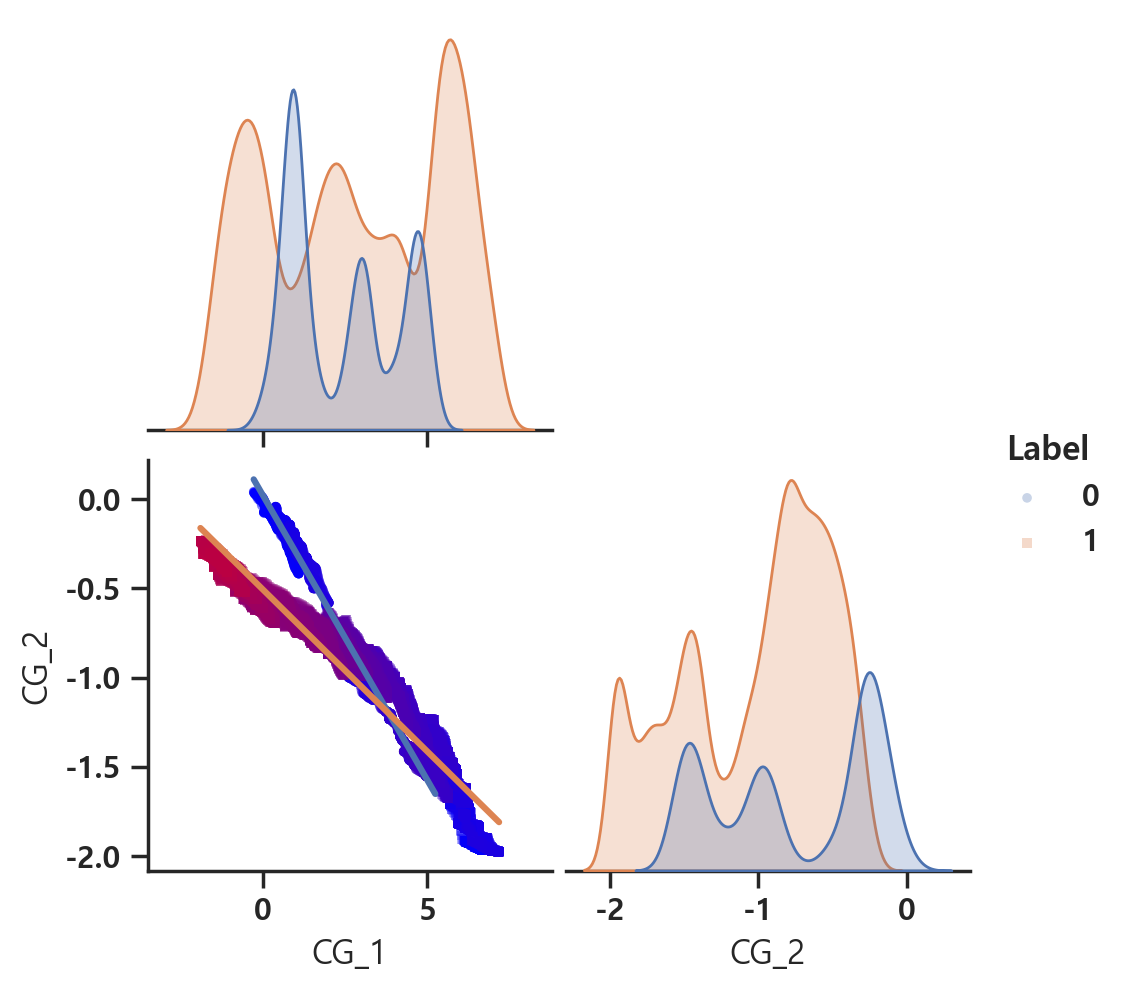

In [19]:
# Define structure of interest
df_interest = df1
# df_interest = df1.iloc[7783:9783, :]
# df_interest = df1.iloc[24252:26252, :]
# df_interest = df1.iloc[28716:30716, :]

# Plot label information
plot_data_labels(df_interest)

# Plot measurements over time
show_lineplots_data(df_interest)

# Plot scatterplots
col_interest = ['Label', 'CG_1', 'CG_2']
show_scatter_plots_data(df_interest, col_interest, df_interest = find_indices_labels(df_interest))

# # Plot scatterplots
# col_interest = ['Label', 'TT_1', 'TT_2']
# show_scatter_plots_data(df_interest, col_interest, df_interest = find_indices_labels(df_interest))
# col_interest = ['Label', 'CG_1', 'TT_1']
# col_interest = ['Label', 'CG_2', 'TT_2']

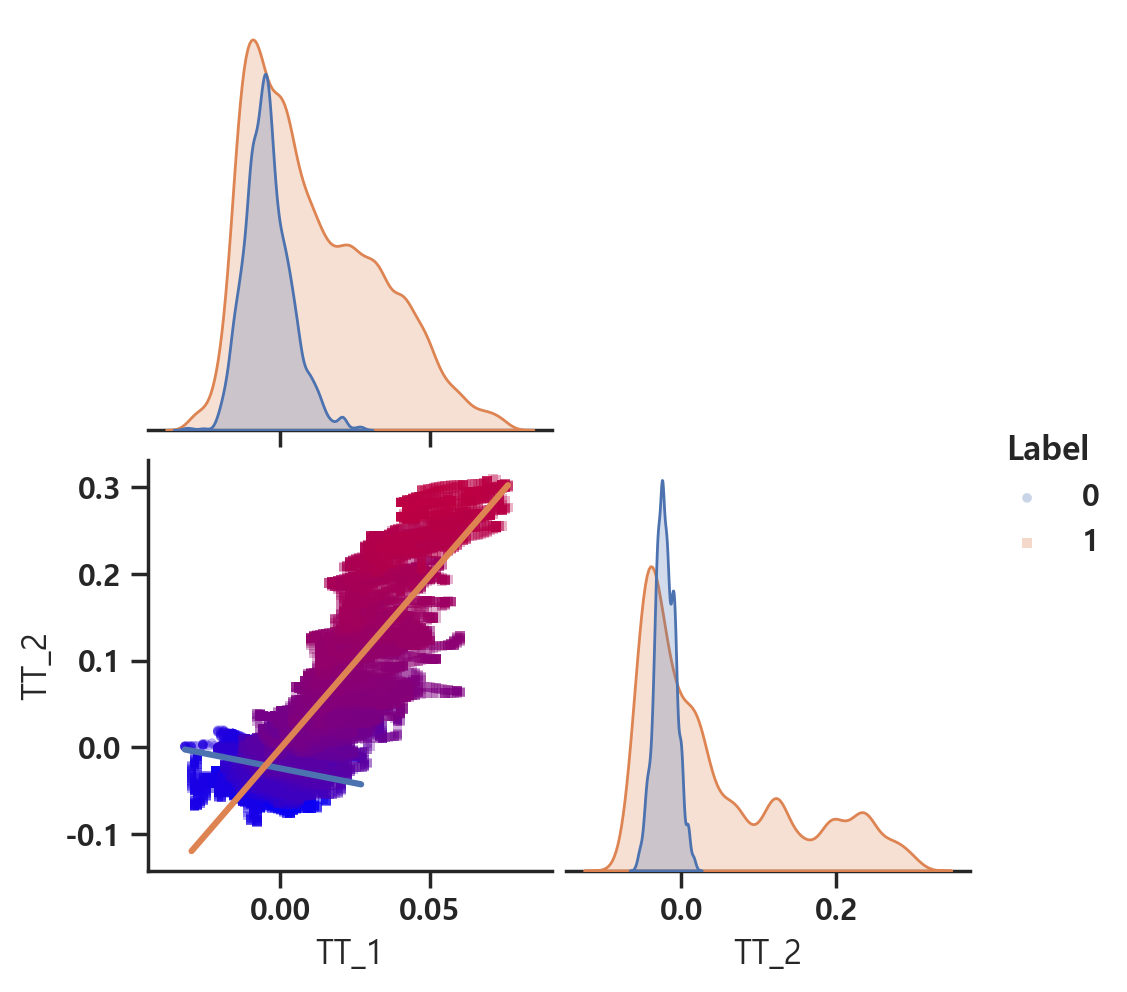

In [20]:
col_interest = ['Label', 'TT_1', 'TT_2']
show_scatter_plots_data(df_interest, col_interest, df_interest = find_indices_labels(df_interest))

In [21]:
if 0:
    # Define structure of interest
    df_interest = df3

    # Plot label information
    plot_data_labels(df_interest)

    # Plot measurements over time
    show_lineplots_data(df_interest)

    # # Extract indices for normal & abnormals
    df_ind = find_indices_labels(df_interest)

    # Plot scatterplots
    col_interest = ['Label', 'CG_3', 'CG_4']
    show_scatter_plots_data(df_interest, col_interest, df_interest = find_indices_labels(df_interest))

#### **Step 2: Save Data**

In [22]:
import pickle

data = {
    'fn': fn_name,
    'damage_ind': damage_ind,
    'data': [df1, df3],
}

# save
with open(fn_name[:-4] + '.pickle', 'wb') as f:
    pickle.dump(data, f)

In [23]:
import pickle

# load
fn_load = 'J_Dataset_1101_0630_outlier_3sig'

with open(fn_load + '.pickle', 'rb') as f:
    data = pickle.load(f)

fn = data['fn']
damage_ind = data['damage_ind']
df1, df3 = data['data'][0], data['data'][1]

#### **Save result**

[How to ensemble Clustering Algorithms](https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265)

[k-means Ensemble 구현과 학습 시 주의할 점](https://lovit.github.io/machine%20learning/2019/02/11/kmeans_ensemble/)

[Hotelling's T^2 scores in python](https://stackoverflow.com/questions/25412954/hotellings-t2-scores-in-python)

=> [is the computed Hoteling's T square correct?](https://stats.stackexchange.com/questions/333179/is-the-computed-hotelings-t-square-correct)

=> [Anomaly Detectiont — Hotelling’s T2 Statistic](https://medium.com/datascience-devops/anomaly-detectiont-hotellings-t2-statistic-cffb833c3052)